# **Assignment 2**

In [165]:
%matplotlib inline
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from pathlib import Path
import pandas_profiling
import sklearn



# **1. Big Picture**

# **2. Get The Data**

In [166]:
test_data = pd.read_csv(r'C:\GitRepos\ML\Assignment3_ML\Data\train.csv')
train_copy = test_data.copy()



# **3. Explore the data to gain insights**

In [167]:
train_copy.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


The third entry shows \n has been used for newline. Lets fix this using regex so it does not interfere with our analysis.

In [168]:
train_copy['full_text'] = train_copy['full_text'].replace(r'\n',' ', regex=True).replace(r'\r',' ', regex=True)

In [169]:
train_copy.describe()

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
count,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000
mean,3.127077,3.028254,3.235745,3.116850,3.032856,3.081053
std,0.662542,0.644399,0.583148,0.655997,0.699841,0.671450
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.500000,2.500000,3.000000,2.500000,2.500000,2.500000
50%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
75%,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [170]:
train_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3911 entries, 0 to 3910
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   text_id      3911 non-null   object 
 1   full_text    3911 non-null   object 
 2   cohesion     3911 non-null   float64
 3   syntax       3911 non-null   float64
 4   vocabulary   3911 non-null   float64
 5   phraseology  3911 non-null   float64
 6   grammar      3911 non-null   float64
 7   conventions  3911 non-null   float64
dtypes: float64(6), object(2)
memory usage: 244.6+ KB


array([[<AxesSubplot:title={'center':'cohesion'}>,
        <AxesSubplot:title={'center':'syntax'}>],
       [<AxesSubplot:title={'center':'vocabulary'}>,
        <AxesSubplot:title={'center':'phraseology'}>],
       [<AxesSubplot:title={'center':'grammar'}>,
        <AxesSubplot:title={'center':'conventions'}>]], dtype=object)

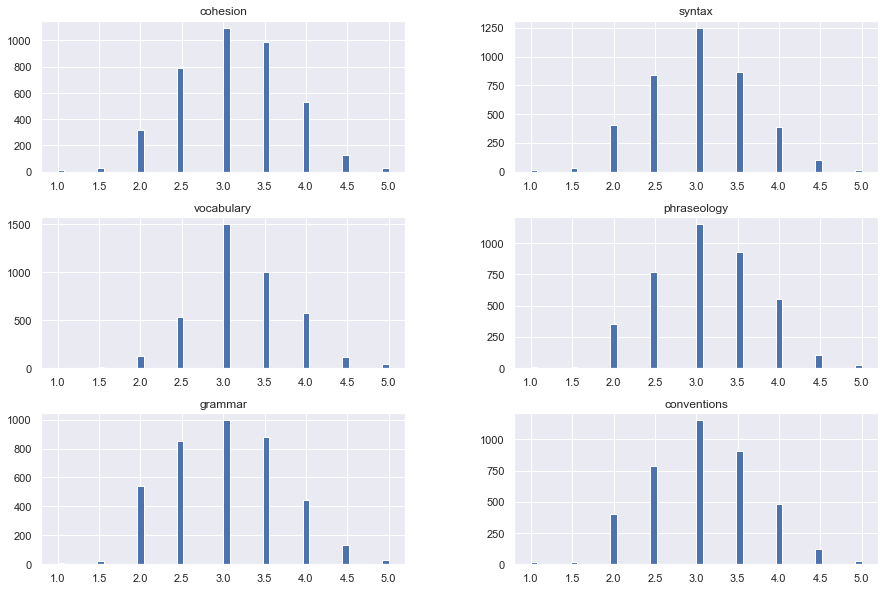

In [171]:
train_copy.hist(bins=50, figsize=(15,10))

nevne om at er 6 target values

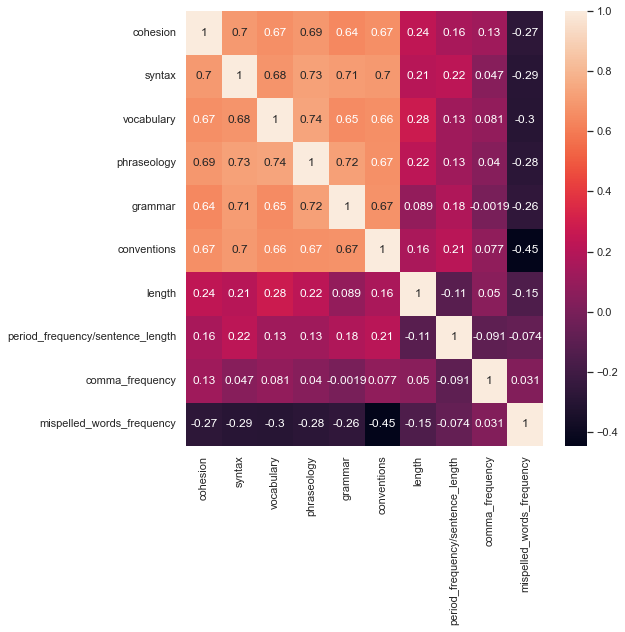

In [185]:
sns.heatmap(train_copy.corr(), annot =True )
sns.set(rc = {'figure.figsize':(8,8)})
plt.show()

#  **4. Prepare the data to better expose the underlying data patterns to machine learning algorithms**

## **The approach**

Machine learning models can't "read" the text in the same way us humans can.
I'll have to create new features that represent the text in a format the algorithm can understand.

Presumably the best way to start is to add a "length" feature. I'll be using this so the algorithm does not dsicriminate based of length of an essay.
A human can easily say 1 grammatical mistake in 10 words is more severe than 2 mistakes in 100 words, the algorithm does not *necessarily*.

We don't actually know if the essays vary much in size, but it's only one way to find out.

In [173]:
train_copy['length'] = train_copy['full_text'].str.len()
train_copy.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,length
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,1387
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,2635
2,00299B378633,"Dear, Principal If u change the school policy...",3.0,3.5,3.0,3.0,3.0,2.5,1663
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,3973
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,1326


In [174]:
print(train_copy['length'].min())
print(train_copy['length'].max())

82
6044


Turns out the longest essay is nearly 100 times longer than the shortest. This information is clearly useful, atleast for further feature engineering.

The features added from now on will mostly be trial and error. I am obviously no expert on linguistics, and the features added will be based on gut feelings. Trying different parameters, and seing what sticks. Mostly based of feature importance.

These are some points/thoughts I will try to base my features off:
- Long sentences are often hard to understand/follow.
- Punctuation:
    - Frequency, relates to point above. The longer the sentence, the harder it becomes to follow.
- Grammatical/spelling errors
    - A well written texts seems less likely to include.
    - Difference in severity?
- Vocabulary:
    - What words - what frequency.
    - Length of words
    
- Length of text could be an important feature for accuracy in the training set, but should not be used. We want the algorithm to rate the quality of the text independently of the length for new data

I will go through this list iteratively.
All features will be added in relation to length of essay with the help of creating a frequency function.
Takes literal to count divides by length and returns.

In [175]:
from collections import Counter

def frequencyChars(text, chars, combine):

    count = Counter(text)
    occurences = list(range(0))
    char_occ = 0
    length = len(text)

    for c in chars:

        char_occ = count.get(c)
        if char_occ is None:

            char_occ = 0
        
        occurences.append(char_occ/length)

    if combine:
        return sum(occurences)

    return occurences

def frequencyWord(text, word):
    occurences = text.count(word)

    return occurences/len(text)

## **Long Sentences/Punctuation**

Adding 2 new features. Length/sentence, frequency of commas and periods.

In [176]:
train_copy['period_frequency/sentence_length'] = train_copy.apply(lambda x: frequencyChars(x['full_text'], '.', True),  axis = 1)

train_copy['comma_frequency'] = train_copy.apply(lambda x: frequencyChars(x['full_text'], ',', True),  axis = 1)

##train_copy['u_frequency'] = train_copy.apply(lambda x: frequencyWord(x['full_text'], 'u'),  axis = 1)

##train_copy['and_frequency'] = train_copy.apply(lambda x: frequencyWord(x['full_text'], 'and'), axis=1)

##train_copy['excPoin/queMark_frequency'] = train_copy.apply(lambda x: frequencyChars(x['full_text'], ['!', '?'], True),  axis = 1)

In [177]:
train_copy.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,length,period_frequency/sentence_length,comma_frequency
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,1387,0.012978,0.000721
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,2635,0.005313,0.001518
2,00299B378633,"Dear, Principal If u change the school policy...",3.0,3.5,3.0,3.0,3.0,2.5,1663,0.011425,0.004209
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,3973,0.009061,0.009816
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,1326,0.002262,0.000000


## **Grammatical/Spelling errors**

Let's go through and check for spelling errors. We'll also store these in our dataframe for easier access later on.

In [178]:
##pip install pyspellchecker
from spellchecker import SpellChecker
import string

In [179]:

def mispelledWords(text):

    spell = SpellChecker()

    words = text.lower().translate(str.maketrans(' ', ' ', string.punctuation)).split()

    mispelled = spell.unknown(words)

    return mispelled 



The 2 first lines below are used for finding mispelled words and frequency of mispelled words in each essay.
These 2 take 5 minutes or so. I therefore stored the results in an csv file and add them back into the dataframe. Some formatting needs to be done, as the set is stored to the csv as a string and the csv adds a column.
This saves a lot of time when running for testing purposes.

In [180]:
##train_copy['mispelled_words'] = train_copy.apply(lambda x: mispelledWords(x['full_text']),  axis = 1)
##train_copy['mispelled_words_frequency'] = train_copy.apply(lambda x: len(x['mispelled_words'])/x['length'],  axis = 1)

##mispelled_words = train_copy['mispelled_words']
##mispelled_words_frequency = train_copy['mispelled_words_frequency']

##mispelled_words_and_frequency = pd.concat((mispelled_words, mispelled_words_frequency), axis = 1)
##mispelled_words_and_frequency.to_csv(r'C:\GitRepos\ML\Assignment3_ML\Data\mispelled_words.csv')

mispelled_words_and_frequency = pd.read_csv(r'C:\GitRepos\ML\Assignment3_ML\Data\mispelled_words.csv')
mispelled_words_and_frequency = mispelled_words_and_frequency.iloc[: , 1:]

mispelled_words_and_frequency['mispelled_words'] = mispelled_words_and_frequency['mispelled_words'].replace(['set()'],'')

mispelled_words_and_frequency['mispelled_words'] = mispelled_words_and_frequency.mispelled_words.apply(lambda x: x[1:-1].translate(str.maketrans(' ', ' ', string.punctuation)).split())

train_copy = train_copy.join(mispelled_words_and_frequency)



In [181]:
train_copy.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,length,period_frequency/sentence_length,comma_frequency,mispelled_words,mispelled_words_frequency
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,1387,0.012978,0.000721,[homebecause],0.000721
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,2635,0.005313,0.001518,[],0.000000
2,00299B378633,"Dear, Principal If u change the school policy...",3.0,3.5,3.0,3.0,3.0,2.5,1663,0.011425,0.004209,"[b, c, isnt, d, shouldnt]",0.003007
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,3973,0.009061,0.009816,"[doesnt, theyre, youre]",0.000755
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,1326,0.002262,0.000000,"[homeles, kindess, thoose, trowing, greate, wo...",0.005279


# **5. Explore many different models and short-list the best ones**

In [182]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
'''
class add_features_transformer(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        
        findLength(X)

        return X

    def findLength(df):
        df['length'] = np.nan
        df['length'] = df['full_text'].str.len()
    

pipe = Pipeline(
    steps=[
        ("findLength", add_features_transformer())
    ]
)

pipe.fit_transform(train_copy)
train_copy.head()
'''

'\nclass add_features_transformer(BaseEstimator, TransformerMixin):\n    \n    def fit(self, X, y=None):\n        return self\n    def transform(self, X, y=None):\n        \n        findLength(X)\n\n        return X\n\n    def findLength(df):\n        df[\'length\'] = np.nan\n        df[\'length\'] = df[\'full_text\'].str.len()\n    \n\npipe = Pipeline(\n    steps=[\n        ("findLength", add_features_transformer())\n    ]\n)\n\npipe.fit_transform(train_copy)\ntrain_copy.head()\n'

# **6. Fine-tune your models and combine them into a great solution**

# **7. Present your solution**

# **8. Launch, monitor, and maintain your system**

In [183]:
'''
train_copy['u_frequency'] = train_copy.apply(lambda x: frequencyWord(x['full_text'], 'u'),  axis = 1)

train_copy['and_frequency'] = train_copy.apply(lambda x: frequencyWord(x['full_text'], 'and'), axis=1)

train_copy['excPoin/queMark_frequency'] = train_copy.apply(lambda x: frequencyChars(x['full_text'], ['!', '?'], True),  axis = 1)
'''

"\ntrain_copy['u_frequency'] = train_copy.apply(lambda x: frequencyWord(x['full_text'], 'u'),  axis = 1)\n\ntrain_copy['and_frequency'] = train_copy.apply(lambda x: frequencyWord(x['full_text'], 'and'), axis=1)\n\ntrain_copy['excPoin/queMark_frequency'] = train_copy.apply(lambda x: frequencyChars(x['full_text'], ['!', '?'], True),  axis = 1)\n"

In [184]:
'''
contractions = ['aren’t',
'can’t', 'couldn’t', 
'didn’t',
'doesn’t', 'don’t', 'hadn’t', 
'hasn’t', 'haven’t', 'he’d', 'he’ll', 'he’s', 
'I’d', 'I’ll', 'I’m', 'I’ve', 'isn’t',
'let’s',
'she’d', 'she’ll', 'she’s', 'shouldn’t',
'that’s','there’s', 'they’d', 'they’ll', 'they’re', 'they’ve ',
'we’d', 'we’re ', 'we’ve', 'weren’t', 'what’ll', 'what’s', 'what’ve', 'where’s', 'who’ll', 'won’t', 'wouldn’t', 
'you’d', 'you’ll', 'you’re', 'you’ve'
] 


contractions_incorrect = list(map(lambda word : word.replace('’',''), contractions))
train_copy['incorrect_contractions'] = train_copy.apply(lambda x: list(set(contractions_incorrect).intersection(x['mispelled_words'])) , axis = 1) 
train_copy['mispelled_contractions_frequency'] = train_copy.apply(lambda x: len(x['incorrect_contractions'])/x['length'],  axis = 1)
train_copy.head()
'''

"\ncontractions = ['aren’t',\n'can’t', 'couldn’t', \n'didn’t',\n'doesn’t', 'don’t', 'hadn’t', \n'hasn’t', 'haven’t', 'he’d', 'he’ll', 'he’s', \n'I’d', 'I’ll', 'I’m', 'I’ve', 'isn’t',\n'let’s',\n'she’d', 'she’ll', 'she’s', 'shouldn’t',\n'that’s','there’s', 'they’d', 'they’ll', 'they’re', 'they’ve ',\n'we’d', 'we’re ', 'we’ve', 'weren’t', 'what’ll', 'what’s', 'what’ve', 'where’s', 'who’ll', 'won’t', 'wouldn’t', \n'you’d', 'you’ll', 'you’re', 'you’ve'\n] \n\n\ncontractions_incorrect = list(map(lambda word : word.replace('’',''), contractions))\ntrain_copy['incorrect_contractions'] = train_copy.apply(lambda x: list(set(contractions_incorrect).intersection(x['mispelled_words'])) , axis = 1) \ntrain_copy['mispelled_contractions_frequency'] = train_copy.apply(lambda x: len(x['incorrect_contractions'])/x['length'],  axis = 1)\ntrain_copy.head()\n"